In [27]:
import pandas as pd

data = pd.read_csv("acn_data.csv")
print(data.head())
print(data.info())


                        _id userInputs  \
0  5bc90cb9f9af8b0d7fe77cd2        NaN   
1  5bc90cb9f9af8b0d7fe77cd3        NaN   
2  5bc90cb9f9af8b0d7fe77cd4        NaN   
3  5bc90cb9f9af8b0d7fe77cd5        NaN   
4  5bc90cb9f9af8b0d7fe77cd6        NaN   

                                sessionID    stationID spaceID  siteID  \
0  2_39_78_362_2018-04-25 11:08:04.400812  2-39-78-362  CA-496       2   
1   2_39_95_27_2018-04-25 13:45:09.617470   2-39-95-27  CA-319       2   
2  2_39_79_380_2018-04-25 13:45:49.962001  2-39-79-380  CA-489       2   
3  2_39_79_379_2018-04-25 14:37:06.460772  2-39-79-379  CA-327       2   
4  2_39_79_381_2018-04-25 14:40:33.638896  2-39-79-381  CA-490       2   

   clusterID                 connectionTime                 disconnectTime  \
0         39  Wed, 25 Apr 2018 11:08:04 GMT  Wed, 25 Apr 2018 13:20:10 GMT   
1         39  Wed, 25 Apr 2018 13:45:10 GMT  Thu, 26 Apr 2018 00:56:16 GMT   
2         39  Wed, 25 Apr 2018 13:45:50 GMT  Wed, 25 Apr 2018 23:04:

In [28]:
print(data.isnull().sum())


_id                   0
userInputs          598
sessionID             0
stationID             0
spaceID               0
siteID                0
clusterID             0
connectionTime        0
disconnectTime        0
kWhDelivered          0
doneChargingTime      1
timezone              0
userID              598
dtype: int64


In [29]:
data = data.dropna(subset=["connectionTime", "kWhDelivered"])


In [30]:
data["connectionTime"] = pd.to_datetime(data["connectionTime"])
data["disconnectTime"] = pd.to_datetime(data["disconnectTime"])


In [31]:
data["hour"] = data["connectionTime"].dt.hour
data["day_of_week"] = data["connectionTime"].dt.dayofweek
data["month"] = data["connectionTime"].dt.month
data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)
data["session_duration"] = (data["disconnectTime"] - data["connectionTime"]).dt.total_seconds() / 3600

In [32]:
data = data[["connectionTime", "hour", "day_of_week", "month", "is_weekend", "kWhDelivered"]]


In [33]:
data["date"] = data["connectionTime"].dt.date

hourly = data.groupby(["date", "hour"]).agg({
    "kWhDelivered": "sum",
    "day_of_week": "first",
    "month": "first",
    "is_weekend": "first"
}).reset_index()

hourly.rename(columns={"kWhDelivered": "energy_demand"}, inplace=True)

print(hourly.head())


         date  hour  energy_demand  day_of_week  month  is_weekend
0  2018-04-25    11          7.932            2      4           0
1  2018-04-25    13         15.270            2      4           0
2  2018-04-25    14         45.453            2      4           0
3  2018-04-25    15         69.505            2      4           0
4  2018-04-25    16         98.398            2      4           0


In [34]:
print(hourly["energy_demand"].describe())


count    193.000000
mean      28.243067
std       29.680468
min        0.546000
25%        8.712000
50%       17.779000
75%       37.178000
max      161.960000
Name: energy_demand, dtype: float64


In [35]:
upper_limit = hourly["energy_demand"].quantile(0.99)

hourly["energy_demand"] = hourly["energy_demand"].clip(upper=upper_limit)


In [36]:
print(hourly["energy_demand"].describe())


count    193.000000
mean      28.111848
std       29.136888
min        0.546000
25%        8.712000
50%       17.779000
75%       37.178000
max      138.019400
Name: energy_demand, dtype: float64


In [37]:
hourly.to_csv("clean_hourly_data.csv", index=False)


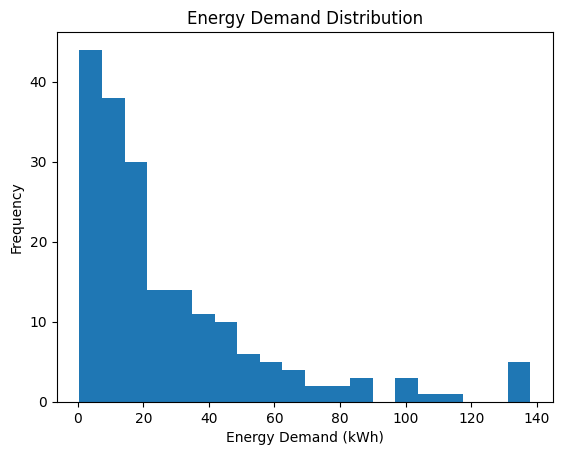

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(hourly["energy_demand"], bins=20)
plt.xlabel("Energy Demand (kWh)")
plt.ylabel("Frequency")
plt.title("Energy Demand Distribution")
plt.show()


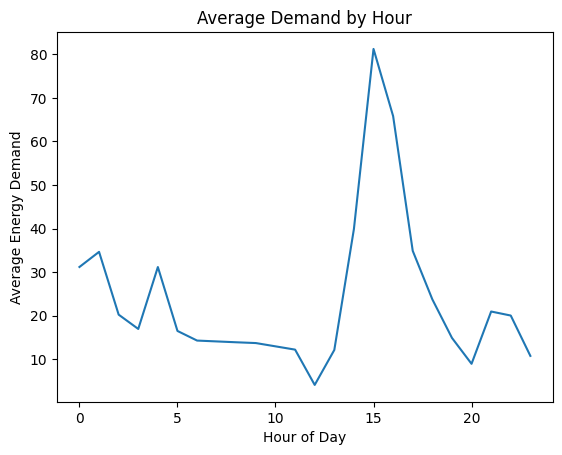

In [39]:
avg_hour = hourly.groupby("hour")["energy_demand"].mean()

plt.figure()
plt.plot(avg_hour.index, avg_hour.values)
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy Demand")
plt.title("Average Demand by Hour")
plt.show()


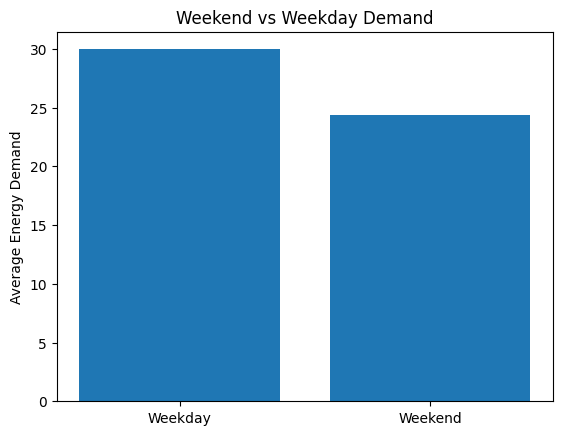

In [40]:
avg_weekend = hourly.groupby("is_weekend")["energy_demand"].mean()

plt.figure()
plt.bar(["Weekday", "Weekend"], avg_weekend.values)
plt.ylabel("Average Energy Demand")
plt.title("Weekend vs Weekday Demand")
plt.show()


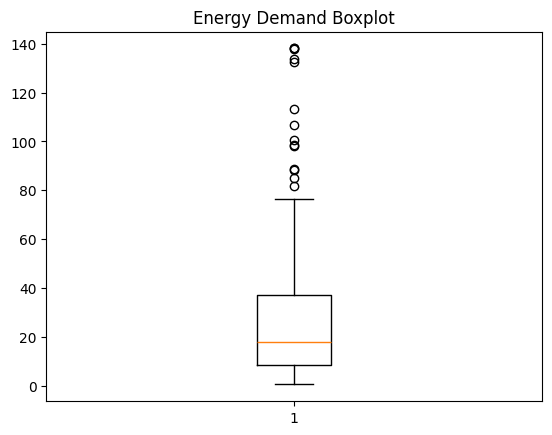

In [41]:
plt.figure()
plt.boxplot(hourly["energy_demand"])
plt.title("Energy Demand Boxplot")
plt.show()


In [42]:
hourly = hourly.sort_values(["date", "hour"])

hourly["prev_hour_demand"] = hourly["energy_demand"].shift(1)

hourly = hourly.dropna()


In [43]:
hourly.to_csv("clean_hourly_data.csv", index=False)

In [44]:
hourly["prev_2_hour_demand"] = hourly["energy_demand"].shift(2)
hourly["prev_3_hour_demand"] = hourly["energy_demand"].shift(3)

hourly = hourly.dropna()
hourly.to_csv("clean_hourly_data.csv", index=False)


In [45]:
hourly["day_of_year"] = pd.to_datetime(hourly["date"]).dt.dayofyear
hourly["week_of_year"] = pd.to_datetime(hourly["date"]).dt.isocalendar().week


In [46]:
hourly["rolling_mean_3"] = hourly["energy_demand"].rolling(3).mean()
hourly["rolling_mean_6"] = hourly["energy_demand"].rolling(6).mean()
hourly["rolling_std_3"] = hourly["energy_demand"].rolling(3).std()

hourly = hourly.dropna()
hourly.to_csv("clean_hourly_data.csv", index=False)
